In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import MDS
import librosa
import IPython.display as ipd
from scipy.io import savemat, loadmat

from rhythmic_features.feature import compute_scale_transform_magnitudes, compute_onset_patterns
from selective_sampling.selective_sampling import fast_votek, diversity, mfl

# Audio examples

In [2]:
basedir = './data/'
filenames = ['[0001] M4-01-SA',
             '[0002] M4-02-SA',
             '[0003] M4-03-PA',
             '[0028] M3-09-MA']

# Rhythmic features

Computing scale transform magnitudes:

In [3]:
STM = []
STM_mean = []
for f in filenames:
    # Load audio file
    filepath = os.path.join(basedir, f+'.wav')
    x, sr = librosa.load(filepath, sr=None)
    
    # Compute STM
    mag_mean, _, _, mag, _, _ = compute_scale_transform_magnitudes(x)
    
    STM.append(mag)
    STM_mean.append(mag_mean)
STM_mean = np.vstack(STM_mean)

Visualizing framewise STM evolution for a single track:

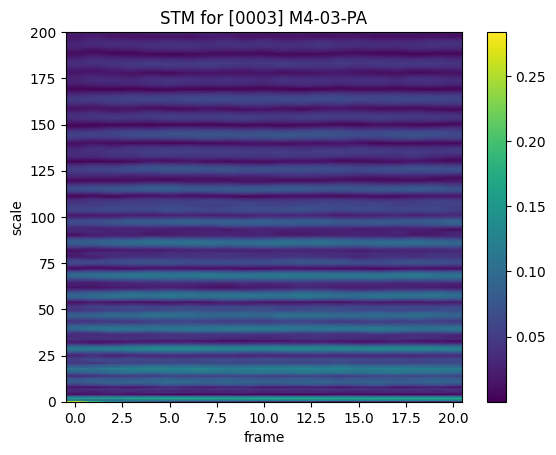

In [4]:
plt.imshow(STM[3], origin='lower', aspect='auto', cmap='viridis')
plt.xlabel('frame')
plt.ylabel('scale')
plt.ylim(0, 200)
plt.title('STM for [0003] M4-03-PA')
plt.colorbar();

Mean STM values of all tracks:

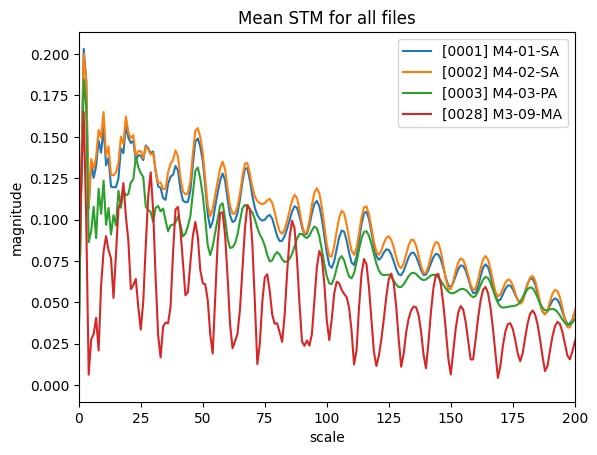

In [5]:
plt.plot(STM_mean.T)
plt.xlabel('scale')
plt.ylabel('magnitude')
plt.xlim(0, 200)
plt.title('Mean STM for all files')
plt.legend(filenames);

We observe that the mean STMs for `[0001] M4-01-SA` and `[0002] M4-02-SA` are very similar (both are examples from the _samba_ genre). `[0003] M4-03-PA` and `[0028] M3-09-MA` correspond to other music styles: _partido-alto_ (which can be regarded as a _samba_ subgenre) and _marcha_.

Let's prepare all frames for a low-dimensional visualization:

In [6]:
X = []
group = []
cdict = {0: 'C0', 1: 'C1', 2: 'C2', 3: 'C3'}
for i in range(len(STM)):
    # Grabbing just the first 200 scale coefficients
    STM_cut = STM[i][:200,:]
    X.append(STM_cut.T)
    
    # Labelling
    n_frames = np.ones(STM_cut.shape[1])
    group.append(i * n_frames)
X = np.vstack(X)
group = np.hstack(group).astype('int')

Transforming the data:

In [7]:
embedding = MDS(n_components=2, random_state=20)
Xt = embedding.fit_transform(X)

Plotting the embedding:

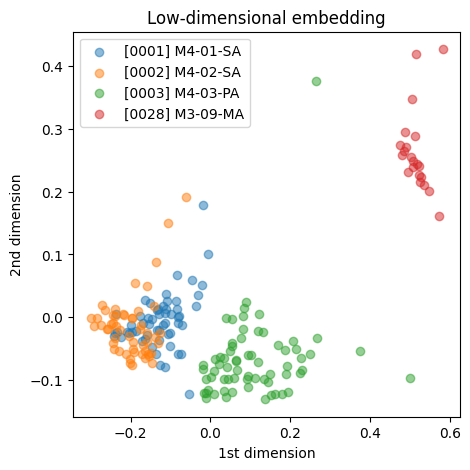

In [8]:
plt.figure(figsize=(5,5))
for g in np.unique(group):
    idx = np.where(group==g)
    plt.scatter(Xt[idx,0], Xt[idx,1], c=cdict[g], label=filenames[g], alpha=0.5)
plt.xlabel('1st dimension')
plt.ylabel('2nd dimension')
plt.title('Low-dimensional embedding')
plt.legend();

# Sample selection

For simplicity, we will perform selection on the frames. In the article, we instead use the mean values per track.

In [9]:
select = 5

Vote-$k$

In [10]:
k = 10
Svtk = fast_votek(X, select, k=10)

voting: 100%|███████████████████████████████████████████████████████████████████████████| 197/197 [00:00<00:00, 1075.28it/s]


Maximum facility location objective

In [11]:
Smfl = mfl(X, select)

100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 3238.34it/s]


Diversity

In [12]:
Sdiv = diversity(X, select)

voting: 100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 1024.10it/s]


$k$-medoids

For this, we use the Matlab function ``get_kmedoids``:

In [13]:
# Saving the features to a file
savemat('features.mat', {'features': X})

# Calling Matlab externally
subprocess.run(['matlab', '-r', f'addpath(\'selective_sampling\');get_kmedoids(\'features.mat\', {select});exit', '-nodisplay', '-nodesktop'],
               stdout=subprocess.DEVNULL);

# Loading selections
Smed = list(loadmat('medoids.mat')['medoids'].flatten() - 1)

Plotting all selections:

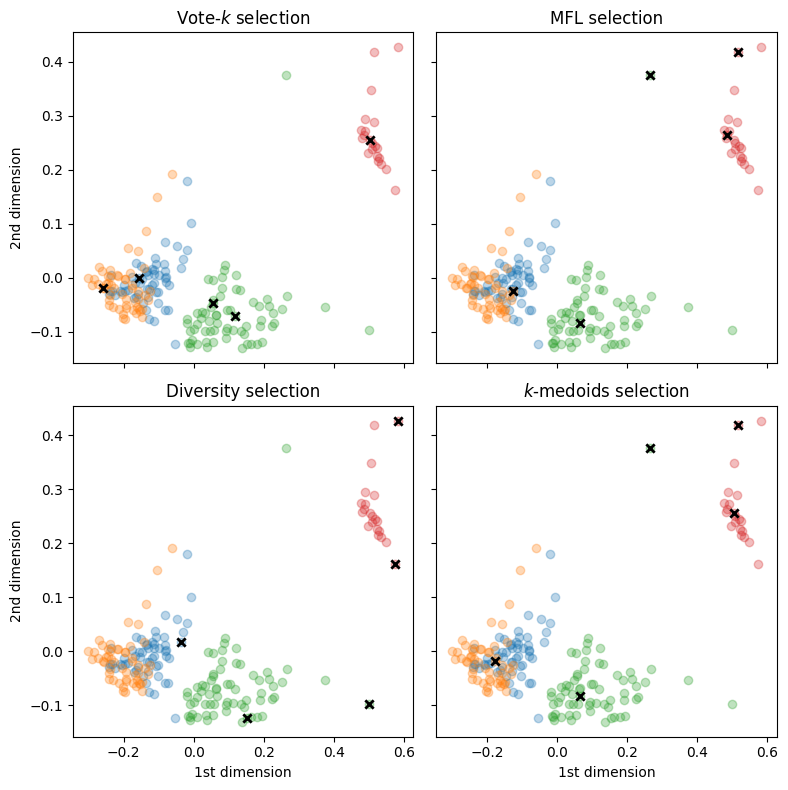

In [14]:
fig, ax = plt.subplots(2,2,figsize=(8,8), sharex=True, sharey=True)

for i in range(2):
    for j in range(2):
        for g in np.unique(group):
            idx = np.where(group==g)
            ax[i,j].scatter(Xt[idx,0], Xt[idx,1], c=cdict[g], label=filenames[g], alpha=0.3)

ax[0,0].scatter(Xt[Svtk, 0], Xt[Svtk, 1], c='k', marker='x', linewidth=2)
ax[0,1].scatter(Xt[Smfl, 0], Xt[Smfl, 1], c='k', marker='x', linewidth=2)
ax[1,0].scatter(Xt[Sdiv, 0], Xt[Sdiv, 1], c='k', marker='x', linewidth=2)
ax[1,1].scatter(Xt[Smed, 0], Xt[Smed, 1], c='k', marker='x', linewidth=2)

ax[1,0].set_xlabel('1st dimension')
ax[1,1].set_xlabel('1st dimension')
ax[0,0].set_ylabel('2nd dimension')
ax[1,0].set_ylabel('2nd dimension')

ax[0,0].set_title('Vote-$k$ selection')
ax[0,1].set_title('MFL selection')
ax[1,0].set_title('Diversity selection')
ax[1,1].set_title('$k$-medoids selection')
plt.tight_layout();